<a href="https://colab.research.google.com/github/Bruno-Messias/data_science_visagio/blob/main/Regressao_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Regressão - Exercício</center>
___

<a id="exercicio"></a>
## 6. Exercícios

Esse notebook contém os exercícios da aula de regressão. Siga as instruções para aplicar o que foi aprendido nessa aula para outra base de dados para tentar prever os preços de carros. Essa base de dados foi disponibilizada junto com o notebook.

Vamos começasr lendo os dados.

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
# Usando outro caminho para obter os csv do google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive/Data\ Science/Entrega5 /mydrive
!ls /mydrive

 dados	'Regressao - Exercicio.ipynb'


In [ ]:
cars_df = pd.read_csv("/mydrive/dados/OLX_Car_Data.csv", encoding = 'unicode_escape')

cars_df.describe(include='all')

,Brand,Condition,Fuel,KMs Driven,Model,Price,Registered City,Transaction Type,Year
count,22836,22837,22528,2.268700e+04,22525,2.497300e+04,20337,22528,22689.000000
unique,23,2,5,NaN,303,NaN,61,2,NaN
top,Suzuki,Used,Petrol,NaN,Cultus VXR,NaN,Karachi,Cash,NaN
freq,9773,18472,14309,NaN,1775,NaN,16599,21513,NaN
mean,NaN,NaN,NaN,1.278112e+05,NaN,9.128953e+05,NaN,NaN,2005.901626
std,NaN,NaN,NaN,5.996726e+05,NaN,1.537134e+06,NaN,NaN,9.563804
min,NaN,NaN,NaN,1.000000e+00,NaN,5.000000e+04,NaN,NaN,1915.000000
25%,NaN,NaN,NaN,1.600000e+04,NaN,3.800000e+05,NaN,NaN,2002.000000
50%,NaN,NaN,NaN,6.651000e+04,NaN,6.500000e+05,NaN,NaN,2008.000000
75%,NaN,NaN,NaN,1.000000e+05,NaN,1.145000e+06,NaN,NaN,2013.000000


Utilizando o método ```describe``` conseguimos ver algumas informações necessárias para fazer uma limpeza básica nos nossos dados. Veja abaixo.

In [ ]:
# renomeando as colunas para remover os espaços
cars_df.rename(columns = {'KMs Driven':'KMs_Driven', 
                          'Registered City':'Registered_City', 
                          'Transaction Type':'Transaction_Type'},
               inplace = True)

# Já que a coluna Model tem muitas categorias, vamos nomear todas com menos de 400 observações de 'Outros'
models = ['Alto', 'Corolla GLI', 'Mehran VX', 'Mehran VXR', 'Vitz', 'Bolan', 'Cuore', 'Corolla XLI', 'Mira']
cars_df.loc[~cars_df['Model'].isin(models),'Model'] = 'Outros'

# removendo valores nulos
cars_df.dropna(axis=0, inplace=True)

# removendo outliers
low = 0.05
high = 0.95
quant_df = cars_df.quantile([low, high])
cars_df = cars_df[(cars_df.KMs_Driven < quant_df.loc[high, "KMs_Driven"]) & 
                  (cars_df.KMs_Driven > quant_df.loc[low, "KMs_Driven"]) &
                  (cars_df.Price < quant_df.loc[high, "Price"]) & 
                  (cars_df.Price > quant_df.loc[low, "Price"]) &
                  (cars_df.Year < quant_df.loc[high, "Year"]) & 
                  (cars_df.Year > quant_df.loc[low, "Year"])]

# transformando as variáveis binárias
cars_df['is_new'] = 1
cars_df.loc[cars_df.Condition == 'Used', 'is_new'] = 0
cars_df.drop(['Condition'], axis=1, inplace=True)

cars_df['is_cash'] = 0
cars_df.loc[cars_df.Transaction_Type=='Cash', 'is_cash'] = 1
cars_df.drop('Transaction_Type', axis=1, inplace=True)

# aplicando o One Hot Encoding
cars_df = pd.concat([cars_df.drop("Brand", axis=1), pd.get_dummies(cars_df.Brand, prefix='Brand')], axis=1)
cars_df = pd.concat([cars_df.drop("Fuel", axis=1), pd.get_dummies(cars_df.Fuel, prefix='Fuel')], axis=1)
cars_df = pd.concat([cars_df.drop("Registered_City", axis=1), pd.get_dummies(cars_df.Registered_City, prefix='RCity')], axis=1)
cars_df = pd.concat([cars_df.drop("Model", axis=1), pd.get_dummies(cars_df.Model, prefix='Model')], axis=1)

cars_df.describe(include='all')

,KMs_Driven,Price,Year,is_new,is_cash,Brand_Audi,Brand_BMW,Brand_Changan,Brand_Chevrolet,Brand_Classic & Antiques,Brand_Daewoo,Brand_Daihatsu,Brand_FAW,Brand_Honda,Brand_Hyundai,Brand_KIA,Brand_Land Rover,Brand_Lexus,Brand_Mazda,Brand_Mercedes,Brand_Mitsubishi,Brand_Nissan,Brand_Other Brands,Brand_Porsche,Brand_Range Rover,Brand_Subaru,Brand_Suzuki,Brand_Toyota,Fuel_CNG,Fuel_Diesel,Fuel_Hybrid,Fuel_LPG,Fuel_Petrol,RCity_Abbottabad,RCity_Ali Masjid,RCity_Askoley,RCity_Attock,RCity_Badin,RCity_Bagh,RCity_Bahawalnagar,...,RCity_Kasur,RCity_Khairpur,RCity_Khanewal,RCity_Khanpur,RCity_Khaplu,RCity_Khushab,RCity_Kohat,RCity_Lahore,RCity_Larkana,RCity_Mandi Bahauddin,RCity_Mardan,RCity_Mirpur,RCity_Multan,RCity_Nawabshah,RCity_Nowshera,RCity_Okara,RCity_Pakpattan,RCity_Peshawar,RCity_Quetta,RCity_Rahimyar Khan,RCity_Rawalpindi,RCity_Sahiwal,RCity_Sargodha,RCity_Sheikhüpura,RCity_Sialkot,RCity_Sukkar,RCity_Sukkur,RCity_Tank,RCity_Vehari,RCity_Wah,Model_Alto,Model_Bolan,Model_Corolla GLI,Model_Corolla XLI,Model_Cuore,Model_Mehran VX,Model_Mehran VXR,Model_Mira,Model_Outros,Model_Vitz
count,14498.000000,1.449800e+04,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,...,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000
mean,76730.142847,7.807886e+05,2006.757622,0.139743,0.972824,0.000345,0.000828,0.000345,0.002621,0.000069,0.002966,0.095806,0.001586,0.155125,0.014278,0.005932,0.000069,0.000621,0.004414,0.002345,0.018899,0.026969,0.004001,0.000069,0.000138,0.000897,0.455097,0.206580,0.301214,0.009932,0.031729,0.000483,0.656642,0.000621,0.000207,0.000138,0.000276,0.000138,0.000207,0.000069,...,0.000276,0.000207,0.000276,0.000207,0.000069,0.000069,0.000207,0.104083,0.000138,0.000069,0.000276,0.000207,0.006208,0.000207,0.000207,0.000276,0.000069,0.002897,0.000759,0.000690,0.007656,0.000138,0.000414,0.000069,0.002000,0.000138,0.000276,0.000069,0.000207,0.000069,0.087529,0.031315,0.050697,0.029452,0.030211,0.049041,0.038626,0.028280,0.623327,0.031522
std,48129.383137,4.369079e+05,6.702141,0.346733,0.162602,0.018568,0.028759,0.018568,0.051131,0.008305,0.054381,0.294336,0.039800,0.362036,0.118638,0.076792,0.008305,0.024908,0.066296,0.048372,0.136174,0.161999,0.063125,0.008305,0.011745,0.029932,0.497997,0.404866,0.458801,0.099169,0.175282,0.021969,0.474846,0.024908,0.014384,0.011745,0.016609,0.011745,0.014384,0.008305,...,0.016609,0.014384,0.016609,0.014384,0.008305,0.008305,0.014384,0.305379,0.011745,0.008305,0.016609,0.014384,0.078547,0.014384,0.014384,0.016609,0.008305,0.053747,0.027535,0.026255,0.087167,0.011745,0.020340,0.008305,0.044681,0.011745,0.016609,0.008305,0.014384,0.008305,0.282619,0.174173,0.219385,0.169077,0.171174,0.215962,0.192709,0.165777,0.484568,0.174729
min,2.000000,1.550000e+05,1987.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000

In [ ]:
y, X = cars_df.Price, cars_df.drop('Price', axis=1)

print("X", X.shape)
print("y", y.shape)

X (14498, 96)
y (14498,)


In [ ]:
seed = 1

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25) #, stratify=y)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

# separando treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                                                  test_size=0.33) #, stratify=y_training)

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (3625, 96)
Test set y (3625,)
Train set X (7284, 96)
Train set y (7284,)
Validation set X (3589, 96)
Validation set y (3589,)


#### Exercício 1

**Substitua as lacunas** para treinar um modelo de *random forest* com validação cruzada e *grid search*. O *grid search* deve variar, pelo menos, os parâmetros *n_estimators* e *max_depth*, mas você pode incluir outros. Após o treino, crie o *dataframe* ```cv_results``` com os resultados de cada iteração e o dicionário ```cv_best_params``` com os valores da melhor combinação de parâmetros.

In [ ]:
# Random Forest com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 9, 13],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'max_depth': 50, 'max_features': 13, 'min_samples_split': 8, 'n_estimators': 500}


#### Exercício 2

**Substitua as lacunas** para treinar o modelo final de *random forest* com os melhores parâmetros obtidos no *grid search* do exercício anterior.

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0])) 
# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(X_training, y_training)
best_model_params = rf_model_cv_gs.get_params()

Average accuracy on train set: -120444.232 +/- 770.748
Average accuracy on validation set: -173288.302 +/- 6005.583


#### Exercício 3

**Substitua as lacunas** para obter um *dataframe* com a importância de cada variável do modelo de *random forest*.

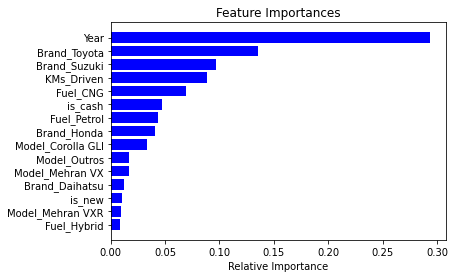

In [ ]:
# desenhando o gráfico de importância de variáveis
features = X_training.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

#### Exercício 4

**Substitua as lacunas** para calcular o RMSE do modelo de *random forest* final na base de teste.

In [ ]:
y_test_pred_rf = rf_model_cv_gs.predict(X_test)
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(rmse_test_rf)

166742.34632465875


#### Exercício 5

**Substitua as lacunas** para treinar um modelo de *Light GBM* com validação cruzada e *grid search*. O *grid search* deve variar, pelo menos, os parâmetros *learning_rate* e *n_estimators*, mas você pode incluir outros. Após o treino, crie o *dataframe* ```cv_results``` com os resultados de cada iteração e o dicionário ```cv_best_params``` com os valores da melhor combinação de parâmetros.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Light GBM com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
# params = {'max_depth': [10, 50, 100],
#           'learning_rate': [0.01, 0.03, 0.1, 0.5],
#           'num_iterations': [100, 200, 500],
#           'min_data_in_leaf': [20, 50],
#           'min_gain_to_split': [0., 1, 5]}

params = {'max_depth': [10, 50, 100],
          'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'num_iterations': [100, 200, 500],
          'min_data_in_leaf': [20, 50],
          'min_gain_to_split': [0., 1, 5]}

# criando o objeto do modelo com XGBClassifier
lgb_model_cv_gs = lgb.LGBMRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(lgb_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'learning_rate': 0.03, 'max_depth': 10, 'min_data_in_leaf': 20, 'min_gain_to_split': 5, 'num_iterations': 500}


#### Exercício 6

**Substitua as lacunas** para treinar o modelo final de *light GBM* com os melhores parâmetros obtidos no *grid search* do exercício anterior.

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.set_params(max_depth = grid_search.best_params_['max_depth'],
                           learning_rate = grid_search.best_params_['learning_rate'],
                           min_data_in_leaf = grid_search.best_params_['min_data_in_leaf'],
                           min_gain_to_split = grid_search.best_params_['min_gain_to_split'])

# treinando um modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.fit(X_training, y_training)
best_model_params = lgb_model_cv_gs.get_params()

Average accuracy on train set: -148863.359 +/- 1120.330
Average accuracy on validation set: -171900.130 +/- 4856.291


#### Exercício 7

**Substitua as lacunas** para obter um *dataframe* com a importância de cada variável do modelo de *light GBM*.

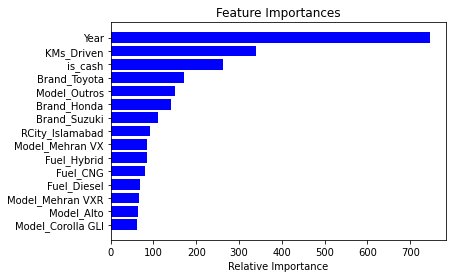

In [ ]:
# desenhando o gráfico de impoartância de variáveis
features = X_training.columns
importances = lgb_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

#### Exercício 8

**Substitua as lacunas** para calcular o RMSE do modelo de *light GBM* final na base de teste.

In [ ]:
y_test_pred_lgb = lgb_model_cv_gs.predict(X_test)
rmse_test_lgb = math.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(rmse_test_lgb)

174500.91971972145


Os resultados dos modelos criados até aqui fazem sentido para você?

Vamos desenhar gráficos para comparar as duas previsões como fizamos com os dados de **boston**, e usá-los para responder as demais perguntas:

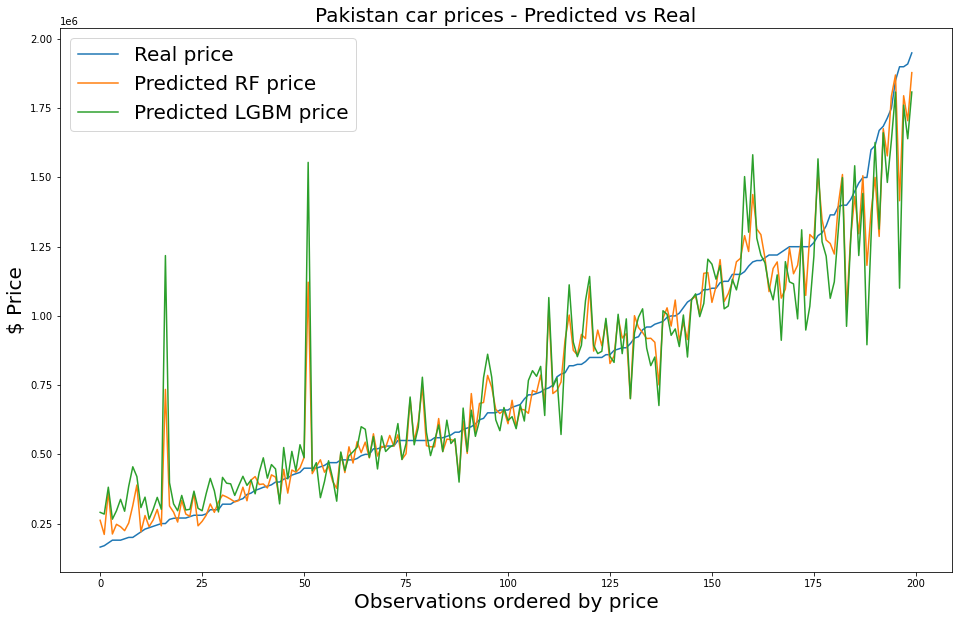

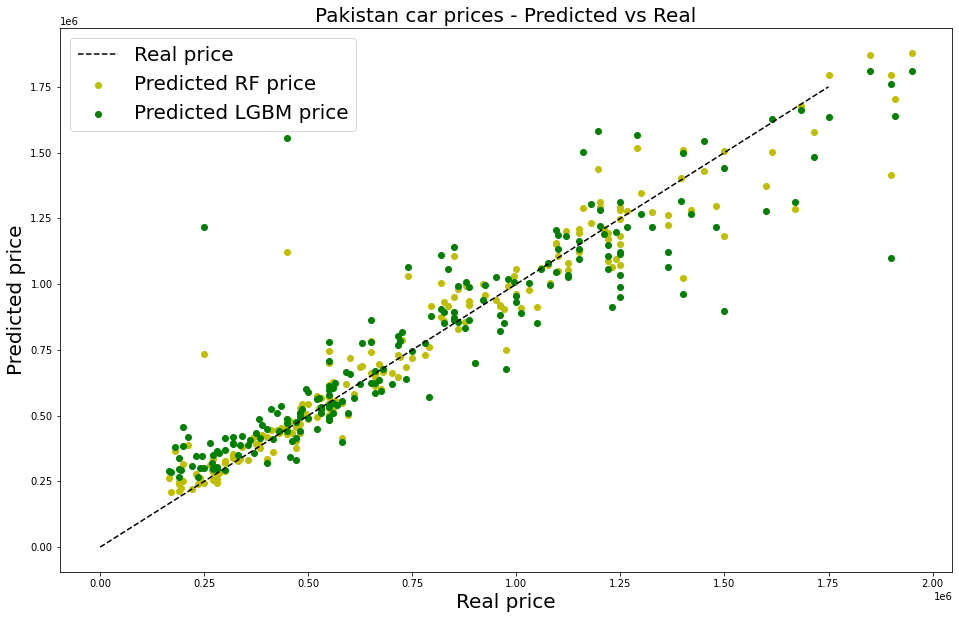

In [ ]:
# Desenhando o gráfico de valores previstos por valores reais para ambos os modelos

plt.figure(figsize=(16,10))
plt.title('Pakistan car prices - Predicted vs Real',fontsize=20)
df = pd.DataFrame({'real':y_val,'Random Forest':rf_model_cv_gs.predict(X_val),
                   'LGBM':lgb_model_cv_gs.predict(X_val)})
df = df.sample(200)
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real price','Predicted RF price','Predicted LGBM price'],fontsize=20)
plt.ylabel('$ Price',fontsize=20)
plt.xlabel('Observations ordered by price',fontsize=20)
plt.show()

plt.figure(figsize=(16,10))
plt.title('Pakistan car prices - Predicted vs Real',fontsize=20)
plt.scatter(x=df['real'],y=df['Random Forest'],c='y')
plt.scatter(x=df['real'],y=df['LGBM'],c='g')
plt.plot([0,1750000],[0,1750000],'k--')
# plt.axis([0,1750000,0,1750000])
plt.legend(['Real price','Predicted RF price','Predicted LGBM price'],fontsize=20)
plt.xlabel('Real price',fontsize=20)
plt.ylabel('Predicted price',fontsize=20)
plt.show()

#### Exercício 9
*(Resposta aberta, não contabilizara pontos, o objetivo é refletir sobre a questão/tópico)*

Qual modelo parece ter menos *over-fitting*? Explique

In [ ]:
# suas respostas
LGBM, por possuirem picos mais acentuados

#### Exercício 10
*(Resposta aberta, não contabilizara pontos, o objetivo é refletir sobre a questão/tópico)*

Qual modelo faz a melhor previsão dos preços dos carros em cada faixa de preço?

In [ ]:
# suas respostas
O modelo de random florest

#### Exercício 11
*(Resposta aberta, não contabilizara pontos, o objetivo é refletir sobre a questão/tópico)*

Qual modelo vocês utilizaria afinal? Explique

In [ ]:
# suas respostas
Provavelmente o modelo RF, por se adequar mais aos resultados obtidos